## === Imports and Setup ===

In [1]:
import os
from time import time
import json

import tables
import numpy as np
from tqdm import tqdm
import pylab as plt 
import pandas as pd
from joblib import dump, load
from scipy.stats import zscore

from sklearn.decomposition import PCA as pca
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

In [2]:
# Load paths
with open('path_vars.json','r') as path_file:
    path_vars = json.load(path_file)

h5_path = path_vars['h5_path'] # Path to HDF5 file where waveform data is stored
model_save_dir = path_vars['model_save_dir'] # Directory in which trained model will be saved

## === Load Data ===

In [3]:
# Load equal numbers of waveforms for pos,neg, split into train,test
# Since positive samples are >> negative, we will subsample from them
neg_path = '/sorted/neg'
pos_path = '/sorted/pos'

neg_waveforms = []
pos_waveforms = []

h5 = tables.open_file(h5_path, 'r')
for x in h5.iter_nodes(neg_path):
    neg_waveforms.append(x[:])

neg_waveforms = np.concatenate(neg_waveforms, axis=0)

# pos_waveforms needs to be of length 75, or 750 that can be downsampled
pos_node_list = list(h5.iter_nodes(pos_path))
# Waveforms with same length as neg_waveforms
pos_matched_units = [x for x in pos_node_list
                     if x.shape[1] == neg_waveforms.shape[1]]
waveforms_per_unit = neg_waveforms.shape[0]//len(pos_matched_units)

# with tables.open_file(h5_path,'r') as h5:
for x in pos_matched_units:
    ind = np.min([x.shape[0], waveforms_per_unit])
    pos_waveforms.append(x[:ind, :])
pos_waveforms = np.concatenate(pos_waveforms, axis=0)
h5.close()

neg_label = [0]*neg_waveforms.shape[0]
pos_label = [1]*pos_waveforms.shape[0]
fin_labels = np.concatenate([neg_label, pos_label])

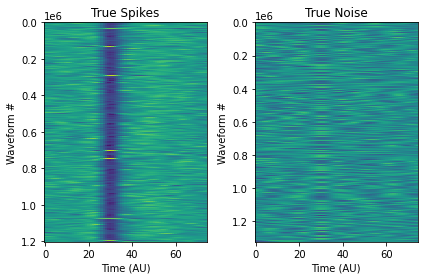

In [7]:
# Plot arrays
fig, ax = plt.subplots(1,2)
ax[0].imshow(zscore(pos_waveforms,axis=-1), interpolation='nearest', aspect = 'auto')
ax[0].set_title('True Spikes')
ax[0].set_xlabel('Time (AU)')
ax[0].set_ylabel('Waveform #')
ax[1].imshow(zscore(neg_waveforms,axis=-1), interpolation='nearest', aspect = 'auto')
ax[1].set_title('True Noise')
ax[1].set_xlabel('Time (AU)')
ax[1].set_ylabel('Waveform #')
plt.tight_layout()

## === Data Preprocessing ===

In [8]:
def zscore_custom(x):
    return zscore(x, axis=-1)
zscore_transform = FunctionTransformer(zscore_custom)

# Aggregate all waveforms
fin_data = np.concatenate([neg_waveforms, pos_waveforms])
# Zscore to homogenize amplitudes
zscore_fin_data = zscore_transform.transform(fin_data)
# No need to fit PCA to ALL datapoints
pca_obj = pca(n_components=10).fit(zscore_fin_data[::1000])
print(f'Explained variance : {np.sum(pca_obj.explained_variance_ratio_)}')
pca_data = pca_obj.transform(zscore_fin_data)

# Scale PCA components
scaler_obj = StandardScaler().fit(pca_data)
X = scaler_obj.transform(pca_data)
y = fin_labels

Explained variance : 0.9555883080933805


## === Train Classifier ===

In [9]:
# Split into Train, Test, and Validation sets

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.5, random_state=1)

X_train, X_val, y_train, y_val = \
    train_test_split(X_train, y_train, test_size=0.25, random_state=1)

In [11]:
# # Tune tree depth and n_estimators using GridSearchCV
# xgb_model = xgb.XGBClassifier(n_jobs=multiprocessing.cpu_count() // 2)
# clf = GridSearchCV(xgb_model, {'max_depth': [2, 4, 6],
#               'n_estimators': [50, 100, 200]}, verbose=1, n_jobs=2)
# clf.fit(X, y)
# print(clf.best_score_)
# print(clf.best_params_)

# # Write out best_params to json
optim_params_path = os.path.join(model_save_dir, 'optim_params.json')
# with open(optim_params_path,'w') as outfile:
#    json.dump(clf.best_params_, outfile, indent = 4)

In [12]:
# Load optimal hyperparameters from file and recreate model
with open(optim_params_path, 'r') as outfile:
    best_params = json.load(outfile)

clf = xgb.XGBClassifier(**best_params)
clf.fit(X_train, y_train)

/home/abuzarmahmood/anaconda3/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:12:13] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.9661806287076565

In [13]:
print(f'Score on training set : {clf.score(X_train, y_train)}')
print(f'Score on test set : {clf.score(X_test, y_test)}')

Score on training set : 0.9715832648673308
Score on test set : 0.9661806287076565


## === Titrate decision boundaries ===

In [27]:
# Calculate probabilities for all data, and test set, and validation set
val_proba = clf.predict_proba(X_val)[:, 1]
test_proba = clf.predict_proba(X_test)[:, 1]
all_proba = clf.predict_proba(X)[:, 1]


# Priorities in order of importance
#   1) Do not lose any actual neurons (Maximize Recall)
#   2) Discard as many non-neurons as possible
# Threshold for true positives == 99%
wanted_recall = 0.99

# Iterate over thresholds for predicted probabilities by classifier
thresh_vec = np.linspace(0, 1, 100)
true_mean_val = []
for this_thresh in thresh_vec:
    pred_pos = test_proba >= this_thresh
    pred_pos = pred_pos*1
    pred_pos_mean = np.mean(pred_pos[np.where(y_test)[0]])
    true_mean_val.append(pred_pos_mean)
true_mean_val = np.array(true_mean_val)

true_mean_thresh_inds = true_mean_val >= wanted_recall
highest_thresh = np.max(thresh_vec[true_mean_thresh_inds])
print(f'Threshold for 0.99 Recall : {highest_thresh}')

Threshold for 0.99 Recall : 0.17171717171717174


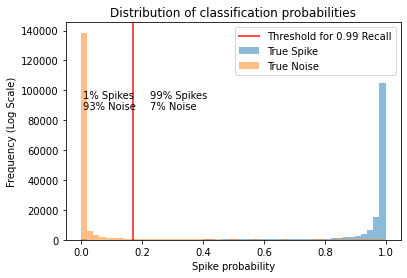

In [34]:
############################################################
# Plot distribution of predicted probabilities
############################################################
discarded_noise = np.mean(val_proba[y_val == 0] < highest_thresh)
discarded_noise_percent = np.int(np.round(discarded_noise*100,0))

left_str = '1% Spikes' + '\n' + f'{discarded_noise_percent}% Noise'
right_str = '99% Spikes' + '\n' + f'{100-discarded_noise_percent}% Noise'

plt.hist(val_proba[np.where(y_val)[0]], bins=50,
         alpha=0.5, label='True Spike')
# plt.yscale('log')
plt.hist(val_proba[np.where(y_val == 0)[0]],
         alpha=0.5, bins=50, label='True Noise')
plt.xlabel('Spike probability')
plt.ylabel('Frequency (Log Scale)')
plt.axvline(highest_thresh,
            color='red', alpha=0.7, linewidth=2,
            label=f'Threshold for {wanted_recall} Recall')
plt.text(0.05, 0.6, left_str, transform=plt.gca().transAxes)
plt.text(0.25, 0.6, right_str, transform=plt.gca().transAxes)
plt.title('Distribution of classification probabilities')
plt.legend()

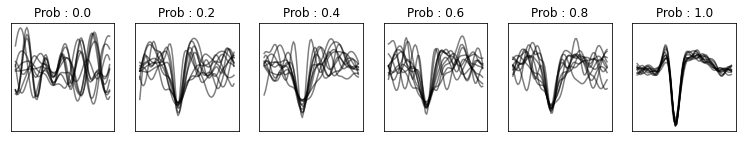

In [35]:
############################################################
# Representative plots of spikes and noise at different probs
############################################################
wanted_probs = np.linspace(0, 1, 6)
prob_frame = pd.DataFrame(
    dict(
        label=y,
        prob=all_proba
    )
)

wav_inds = []
for this_prob in wanted_probs:
    wav_val = (prob_frame['prob'] - this_prob)\
        .abs().argsort()[:10].values
    wav_inds.append(wav_val)

fig, ax = plt.subplots(1, len(wanted_probs), sharey=True,
                       figsize=(13, 2))
for num in range(len(wanted_probs)):
    this_dat = zscore(fin_data[wav_inds[num]], axis=-1)
    flip_bool = np.vectorize(np.int)(np.sign(this_dat[:, 30]))
    this_dat = np.stack([x*-1 if this_bool == 1 else x
                         for x, this_bool in zip(this_dat, flip_bool)])
    ax[num].plot(this_dat.T,
                 color='k', alpha=0.5)
    ax[num].set_title(f'Prob : {np.round(wanted_probs[num],1)}')
    ax[num].set_xticklabels([])
    ax[num].set_xticks([])
    ax[num].set_yticklabels([])
    ax[num].set_yticks([])

In [36]:
############################################################
# Speed Test
############################################################
start_t = time()
clf.predict_proba(X)
end_t = time()
print(end_t-start_t)

0.6441559791564941


## === Write out classifier and pipeline ===

In [38]:
dump(clf, os.path.join(model_save_dir, "xgb_classifier"));

pipeline = Pipeline([
    ('zscore', zscore_transform),
    ('pca', pca_obj),
    ('scaler', scaler_obj),
    ('svc', clf)])
dump(pipeline, os.path.join(model_save_dir, "xgb_pipeline"));